bhaav paper based preprocessing steps


In [ ]:
# Install iNLTK and dependencies
!pip install inltk
!pip install scikit-learn
!pip install pandas


  Using cached inltk-0.9-py3-none-any.whl.metadata (40 kB)
  Using cached async_timeout-5.0.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached nvidia-ml-py3-7.352.0.tar.gz (19 kB)
  Preparing metadata (setup.py) ... done
  Using cached typing-3.7.4.3.tar.gz (78 kB)
  Preparing metadata (setup.py) ... done
  Using cached fastai-1.0.57-py3-none-any.whl.metadata (14 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 145.3 MB/s eta 0:00:00


In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 5.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313474 sha256=3a56de608ccb13490697bb1970c91fc58e28ab2f93ceddd836002f9beab02e5b
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


#below is the current model which gave 77 accuracy


In [ ]:
import pandas as pd
import re  # regex module
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sklearn.utils import resample



due to class imbalance, we applied oversampling and undersampling together to balance dataset. before i tried only oversampling and it didnt work well, nor did only undersampling. this was a random generalized quantity to resample to, but it gave results hence i didnt check it out more.

In [ ]:
# ------------------------- STEP 1: LOADING & RESAMPLING DATA -------------------------

def load_and_resample_data(file_path):

    # Load and resample the dataset using hybrid resampling:
    # - Downsample the majority class
    # - Lightly upsample the minority classes

    try:
        data = pd.read_excel(file_path)
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

    # Remove NaN or empty sentences
    data = data.dropna(subset=['Sentences'])
    data = data[data['Sentences'].str.strip() != '']

    # Convert annotation to int
    data['Annotation'] = data['Annotation'].astype(int)

    print("Original Class Distribution:")
    print(data['Annotation'].value_counts())

    # Separate classes
    class_groups = data.groupby('Annotation')

    # Define resampling strategy
    max_target = 7000  # Target for majority classes after downsampling
    min_target = 5000  # Target for minority classes after upsampling

    resampled_data = []
    for annotation, group in class_groups:
        class_size = len(group)

        if class_size > max_target:
            group_resampled = resample(group, replace=False, n_samples=max_target, random_state=42)
        elif class_size < min_target:
            group_resampled = resample(group, replace=True, n_samples=min_target, random_state=42)
        else:
            group_resampled = group

        resampled_data.append(group_resampled)

    # Combine resampled data
    data_resampled = pd.concat(resampled_data)

    # Shuffle dataset
    data_resampled = data_resampled.sample(frac=1, random_state=42).reset_index(drop=True)

    print("\nResampled Class Distribution:")
    print(data_resampled['Annotation'].value_counts())

    # Save resampled dataset
    data_resampled.to_csv('bhaav_resampled_dataset.csv', index=False)
    print("\nResampled dataset saved as 'bhaav_resampled_dataset.csv'.")

    return data_resampled


# Load and resample dataset
file_path = "/content/Bhaav-Dataset(1).xlsx"
data = load_and_resample_data(file_path)

Original Class Distribution:
Annotation
4    11697
2     3168
1     2463
3     1512
0     1464
Name: count, dtype: int64

Resampled Class Distribution:
Annotation
4    7000
1    5000
3    5000
2    5000
0    5000
Name: count, dtype: int64

Resampled dataset saved as 'bhaav_resampled_dataset.csv'.


In [ ]:


# ------------------------- STEP 2: PREPROCESSING -------------------------

# Text preprocessing
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s\u0900-\u097F]', '', str(text))  # Keep only letters and Hindi characters
    text = re.sub(r'\s+', ' ', text).strip()
    return text

data['Sentences'] = data['Sentences'].apply(preprocess_text)

In [ ]:


# ------------------------- STEP 3: TOKENIZATION -------------------------

print("Tokenizing the dataset...")
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")

data["Sentences"] = data["Sentences"].fillna("").astype(str)

devices = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoded_data = tokenizer.batch_encode_plus(
    data["Sentences"].tolist(),
    padding=True,
    truncation=True,
    max_length=126,  # Updated padding length
    return_tensors="pt"
)

data['Tokens'] = [tokenizer.convert_ids_to_tokens(ids) for ids in encoded_data["input_ids"]]

# Save tokenized dataset
data.to_csv("tokenized_dataset_resampled.csv", index=False)
print("\nTokenized dataset saved as 'tokenized_dataset_resampled.csv'.")

Tokenizing the dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]


Tokenized dataset saved as 'tokenized_dataset_resampled.csv'.


In [ ]:


# ------------------------- STEP 4: GENERATING INDICBERT EMBEDDINGS -------------------------

print("Generating embeddings...")
model = AutoModel.from_pretrained("ai4bharat/indic-bert").to(devices)

def get_embedding(sentence):
    inputs = tokenizer(sentence, padding=True, truncation=True, max_length=126, return_tensors="pt").to(devices)
    with torch.no_grad():  # Disable gradient calculations
        outputs = model(**inputs)
        return outputs.last_hidden_state[:, 0, :].cpu().numpy()

embeddings = np.vstack([get_embedding(sentence) for sentence in data["Sentences"]])

# Save embeddings
np.save("indicbert_embeddings_resampled.npy", embeddings)

print("Sample Embeddings Shape:", embeddings.shape)
print("First Embedding Vector:", embeddings[0])

print("Processing complete!")


Generating embeddings...


pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]

Sample Embeddings Shape: (27000, 768)
First Embedding Vector: [-1.36403996e-03 -7.53259100e-03  1.38697703e-03  7.67967338e-03
 -9.73788556e-03 -5.69646107e-03  1.42348306e-02  1.78280603e-02
 -1.34226242e-02  9.73149482e-03  5.64839924e-03 -1.49707347e-02
  1.55190341e-02  4.26495122e-03  2.57077673e-03 -1.24585358e-02
 -1.65057695e-03 -3.86795611e-03  1.04512163e-02 -1.37272943e-02
  1.93835162e-02 -1.51680792e-02  2.00584065e-02 -2.16349750e-03
 -6.23676972e-03  3.37544344e-02 -1.43443439e-02  1.70345977e-02
 -2.97889113e-03  9.11824871e-03 -9.39487386e-03  1.18653001e-02
  2.38817427e-02 -5.80338994e-03  3.55173857e-03 -4.57819272e-03
 -2.76667299e-03 -2.87796743e-02 -2.65986994e-02  1.35358199e-02
 -5.51781096e-02  3.65382480e-03 -2.20961007e-03 -2.94225104e-03
  1.45103885e-02 -9.63299884e-04 -1.16289677e-02  6.87753130e-03
  1.01461541e-02  1.32414429e-02 -2.63733382e-04  1.34423021e-02
  1.20442109e-02 -2.01320928e-02 -7.36504421e-03 -2.59464583e-03
 -1.32292155e-02 -1.25856847

just oversampling it(leads to lower accuracy)


Loading preprocessed data...
Input size: 768
Number of classes: 5
Total samples: 27000
Training samples: 21600
Testing samples: 5400
Class distribution in training set: [4000 4000 4000 4000 5600]
Class weights: tensor([0.2121, 0.2121, 0.2121, 0.2121, 0.1515])
Using device: cuda
Starting training...
Epoch: 1/100
Train Loss: 1.6169, Train Acc: 23.99%
Val Loss: 1.5868, Val Acc: 26.30%
Learning rate: 0.001000
Epoch: 2/100
Train Loss: 1.5665, Train Acc: 27.88%
Val Loss: 1.5624, Val Acc: 28.72%
Learning rate: 0.001000
Epoch: 3/100
Train Loss: 1.5280, Train Acc: 30.81%
Val Loss: 1.5203, Val Acc: 32.46%
Learning rate: 0.001000
Epoch: 4/100
Train Loss: 1.4954, Train Acc: 33.16%
Val Loss: 1.5310, Val Acc: 30.43%
Learning rate: 0.001000
Epoch: 5/100
Train Loss: 1.4609, Train Acc: 35.34%
Val Loss: 1.4898, Val Acc: 34.54%
Learning rate: 0.001000
Epoch: 6/100
Train Loss: 1.4206, Train Acc: 37.81%
Val Loss: 1.4386, Val Acc: 36.80%
Learning rate: 0.001000
Epoch: 7/100
Train Loss: 1.3776, Train Acc: 40

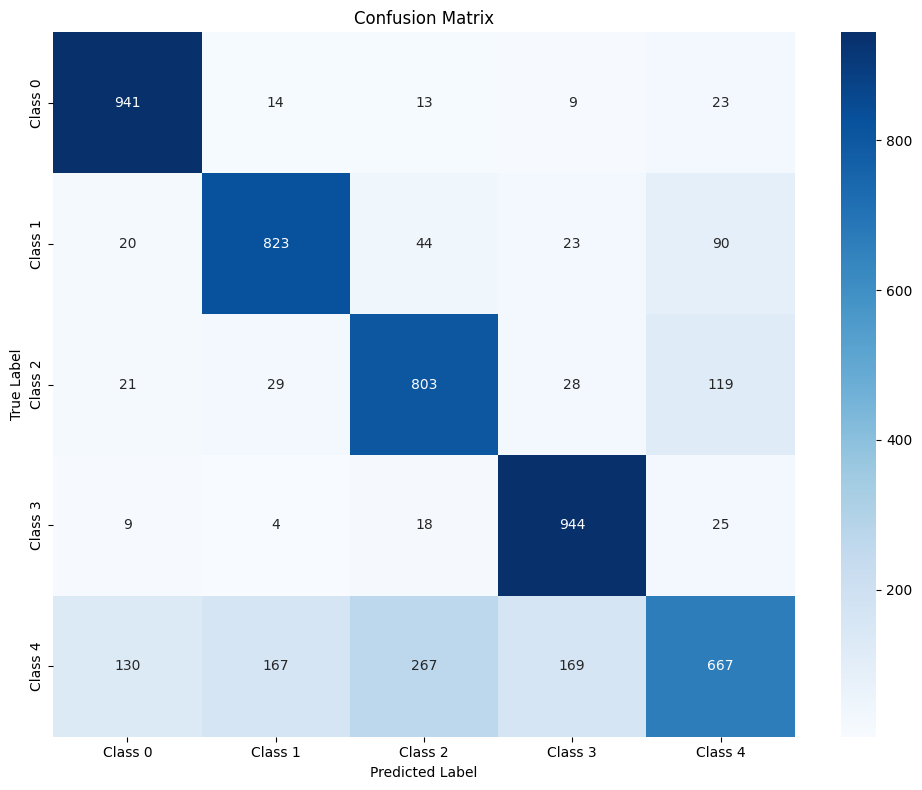

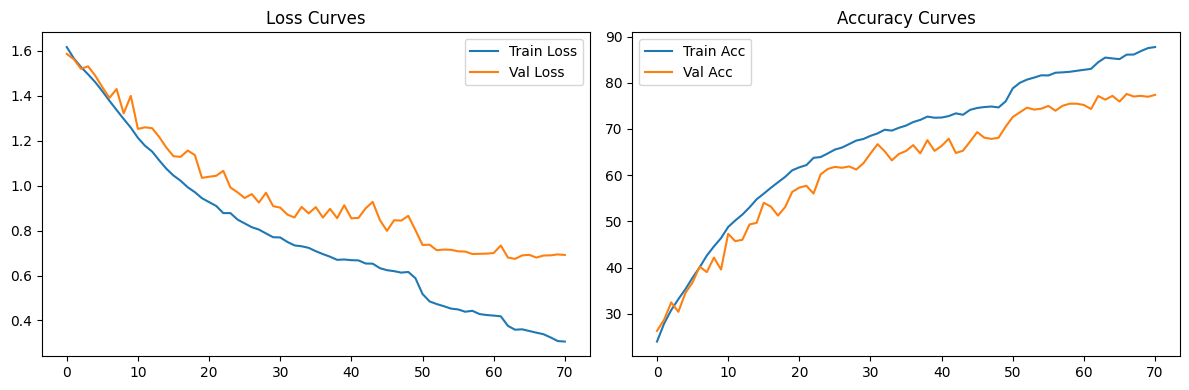

Training completed and model saved!


In [ ]:


# 4. Model Training

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset

# Load preprocessed data
print("Loading preprocessed data...")
embeddings = np.load("indicbert_embeddings_resampled.npy")
data = pd.read_csv("tokenized_dataset_resampled.csv")
labels = data["Annotation"].values

# Get input and output dimensions
input_size = embeddings.shape[1]  # Should be 768 for IndicBERT
num_classes = len(np.unique(labels))
print(f"Input size: {input_size}")
print(f"Number of classes: {num_classes}")
print(f"Total samples: {len(labels)}")

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Calculate class weights for handling imbalance
class_counts = np.bincount(y_train)
print(f"Class distribution in training set: {class_counts}")
class_weights = torch.FloatTensor(1.0 / class_counts)
class_weights = class_weights / class_weights.sum()
print(f"Class weights: {class_weights}")

# Model definition
class EmotionClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(EmotionClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Early stopping implementation
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
      model.train()
      total_loss = 0
      correct = 0
      total = 0

      for batch_idx, (data, target) in enumerate(train_loader):
          data, target = data.to(device), target.to(device)
          optimizer.zero_grad()
          output = model(data)
          loss = criterion(output, target)
          loss.backward()
          optimizer.step()

          total_loss += loss.item()
          _, predicted = output.max(1)
          total += target.size(0)
          correct += predicted.eq(target).sum().item()

      return total_loss/len(train_loader), 100.*correct/total

# Evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    return total_loss/len(test_loader), 100.*correct/total, all_preds, all_targets

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = EmotionClassifier(input_size=input_size, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
early_stopping = EarlyStopping(patience=7)

# Training loop
num_epochs = 100
train_losses = []
train_accs = []
val_losses = []
val_accs = []

print("Starting training...")
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = evaluate(model, test_loader, criterion, device)

    scheduler.step(val_loss)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch: {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print(f'Learning rate: {optimizer.param_groups[0]["lr"]:.6f}')

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered at epoch", epoch+1)
        break

# Final evaluation
_, _, y_pred, y_true = evaluate(model, test_loader, criterion, device)

# Get class labels for better readability
unique_labels = sorted(np.unique(labels))
target_names = [f"Class {label}" for label in unique_labels]

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy Curves')
plt.legend()
plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# Save the model
torch.save(model.state_dict(), 'emotion_classifier_final.pth')
print("Training completed and model saved!")

# Optional: Create a function for inference
def predict_emotion(embedding, model, device):
    model.eval()
    embedding_tensor = torch.FloatTensor(embedding).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(embedding_tensor)
        probabilities = F.softmax(output, dim=1)
        _, predicted = output.max(1)

    return predicted.item(), probabilities.cpu().numpy()[0]

# Optional: Test with a few examples if you have the tokenizer and BERT model loaded
# For a complete prediction function, you would need to include:
# - Text preprocessing
# - Tokenization
# - Embedding generation with IndicBERT
# But that would require having the tokenizer and model loaded

In [ ]:
import torch
import numpy as np
from transformers import AutoModel, AutoTokenizer

# Load IndicBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")
bert_model = AutoModel.from_pretrained("ai4bharat/indic-bert").to("cuda" if torch.cuda.is_available() else "cpu")

# Define EmotionClassifier model (Same as trained)
class EmotionClassifier(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super(EmotionClassifier, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 512)
        self.bn1 = torch.nn.BatchNorm1d(512)
        self.dropout1 = torch.nn.Dropout(0.3)
        self.fc2 = torch.nn.Linear(512, 256)
        self.bn2 = torch.nn.BatchNorm1d(256)
        self.dropout2 = torch.nn.Dropout(0.3)
        self.fc3 = torch.nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Load trained classifier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionClassifier(input_size=768, num_classes=5).to(device)
model.load_state_dict(torch.load("emotion_classifier_final.pth", map_location=device, weights_only=True))
model.eval()

# Hindi test sentences with actual labels
test_data = [
    ("यह मेरी ज़िंदगी का सबसे अच्छा दिन है!", 0),  # Joy
    ("मैं बहुत खुश हूँ कि मैंने अपनी परीक्षा पास कर ली।", 0),  # Joy
    ("वाह! यह खाना कितना स्वादिष्ट है।", 0),  # Joy
    ("मुझे अपने दोस्तों के साथ समय बिताना बहुत पसंद है।", 0),  # Joy
    ("तुमने मुझसे झूठ क्यों बोला?", 1),  # Anger
    ("मुझे धोखा देने की तुम्हारी हिम्मत कैसे हुई?", 1),  # Anger
    ("यह बहुत अन्यायपूर्ण है!", 1),  # Anger
    ("मैं बहुत गुस्से में हूँ, अब बस बहुत हुआ।", 1),  # Anger
    ("अब आगे क्या होगा, मुझे समझ नहीं आ रहा।", 2),  # Suspense
    ("मुझे इस खेल का नतीजा जानने की बहुत उत्सुकता है।", 2),  # Suspense
    ("लगता है कोई हमें देख रहा है।", 2),  # Suspense
    ("मुझे कुछ अजीब सा महसूस हो रहा है।", 2),  # Suspense
    ("मुझे बहुत अकेला महसूस हो रहा है।", 3),  # Sad
    ("वह हमेशा मेरी मदद करता था, अब वह नहीं रहा।", 3),  # Sad
    ("यह दिन मेरी जिंदगी का सबसे दुखद दिन है।", 3),  # Sad
    ("मुझे बहुत बुरा लग रहा है कि मैंने उसे चोट पहुंचाई।", 3),  # Sad
    ("क्या आप मेरी मदद कर सकते हैं?", 4),  # Neutral
    ("यह खबर सुनकर मुझे कोई खास फर्क नहीं पड़ा।", 4),  # Neutral
    ("आज का दिन बस ठीक-ठाक था।", 4),  # Neutral
    ("मुझे नहीं पता कि इस बारे में क्या कहना चाहिए।", 4),  # Neutral
]

# Emotion Labels
emotion_labels = ["Joy (0)", "Anger (1)", "Suspense (2)", "Sad (3)", "Neutral (4)"]

# Function to get embeddings from IndicBERT
def get_embedding(text):
    tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        embeddings = bert_model(**tokens).last_hidden_state[:, 0, :]
    return embeddings

# Test sentences and print results
print("\n📌 Model Predictions vs Actual:\n")
correct = 0

for sentence, actual_label in test_data:
    embedding = get_embedding(sentence)  # Get IndicBERT embeddings
    with torch.no_grad():
        output = model(embedding)  # Predict
        predicted_class = torch.argmax(output, dim=1).item()

    print(f"📝 Sentence: {sentence}")
    print(f"📢 Predicted Emotion: {emotion_labels[predicted_class]}")
    print(f"✅ Actual Emotion: {emotion_labels[actual_label]}\n")

    if predicted_class == actual_label:
        correct += 1

# Accuracy calculation
accuracy = (correct / len(test_data)) * 100
print(f"🎯 Model Accuracy on Test Data: {accuracy:.2f}%")


<ipython-input-19-1f78d7174c91>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("emotion_classifier_final.pth", map_location=device))
Aski


📌 Model Predictions vs Actual:

📝 Sentence: यह मेरी ज़िंदगी का सबसे अच्छा दिन है!
📢 Predicted Emotion: Sad (3)
✅ Actual Emotion: Joy (0)

📝 Sentence: मैं बहुत खुश हूँ कि मैंने अपनी परीक्षा पास कर ली।
📢 Predicted Emotion: Neutral (4)
✅ Actual Emotion: Joy (0)

📝 Sentence: वाह! यह खाना कितना स्वादिष्ट है।
📢 Predicted Emotion: Anger (1)
✅ Actual Emotion: Joy (0)

📝 Sentence: मुझे अपने दोस्तों के साथ समय बिताना बहुत पसंद है।
📢 Predicted Emotion: Neutral (4)
✅ Actual Emotion: Joy (0)

📝 Sentence: तुमने मुझसे झूठ क्यों बोला?
📢 Predicted Emotion: Anger (1)
✅ Actual Emotion: Anger (1)

📝 Sentence: मुझे धोखा देने की तुम्हारी हिम्मत कैसे हुई?
📢 Predicted Emotion: Anger (1)
✅ Actual Emotion: Anger (1)

📝 Sentence: यह बहुत अन्यायपूर्ण है!
📢 Predicted Emotion: Sad (3)
✅ Actual Emotion: Anger (1)

📝 Sentence: मैं बहुत गुस्से में हूँ, अब बस बहुत हुआ।
📢 Predicted Emotion: Neutral (4)
✅ Actual Emotion: Anger (1)

📝 Sentence: अब आगे क्या होगा, मुझे समझ नहीं आ रहा।
📢 Predicted Emotion: Anger (1)
✅ Actua

below is the code for sentiment analysis fine tuning in indicbert from github, and i have changed certain things to tune it to my dataset and needs.
if i have to run this i need to change the dataset and reduce annotations to 3, i can do it later if needed.

Using device: cuda
Loading preprocessed data and embeddings...
Data shape: (27000, 3)
Embeddings shape: (27000, 768)
Emotion distribution:
  Joy: 5000
  Anger: 5000
  Suspense: 5000
  Sad: 5000
  Neutral: 7000
Training set: 19507 samples
Validation set: 3443 samples
Test set: 4050 samples
Using FP32 precision
Starting training...


Epoch 1/5 [Val]: 100%|██████████| 108/108 [00:00<00:00, 211.74it/s, loss=1.61]


Epoch 1/5:
  Train - Loss: 1.6030, Accuracy: 0.2510, F1: 0.1290
  Val   - Loss: 1.5991, Accuracy: 0.2594, F1: 0.1068
  F1 scores per emotion:
    Joy: 0.0000
    Anger: 0.0000
    Suspense: 0.0000
    Sad: 0.0000
    Neutral: 0.4119


Epoch 2/5 [Val]: 100%|██████████| 108/108 [00:00<00:00, 261.50it/s, loss=1.61]


Epoch 2/5:
  Train - Loss: 1.5994, Accuracy: 0.2592, F1: 0.1067
  Val   - Loss: 1.5989, Accuracy: 0.2594, F1: 0.1068
  F1 scores per emotion:
    Joy: 0.0000
    Anger: 0.0000
    Suspense: 0.0000
    Sad: 0.0000
    Neutral: 0.4119


Epoch 3/5 [Val]: 100%|██████████| 108/108 [00:00<00:00, 258.79it/s, loss=1.62]


Epoch 3/5:
  Train - Loss: 1.5990, Accuracy: 0.2592, F1: 0.1067
  Val   - Loss: 1.5987, Accuracy: 0.2594, F1: 0.1068
  F1 scores per emotion:
    Joy: 0.0000
    Anger: 0.0000
    Suspense: 0.0000
    Sad: 0.0000
    Neutral: 0.4119


Epoch 4/5 [Val]: 100%|██████████| 108/108 [00:00<00:00, 426.15it/s, loss=1.62]


Epoch 4/5:
  Train - Loss: 1.5988, Accuracy: 0.2592, F1: 0.1067
  Val   - Loss: 1.5986, Accuracy: 0.2594, F1: 0.1068
  F1 scores per emotion:
    Joy: 0.0000
    Anger: 0.0000
    Suspense: 0.0000
    Sad: 0.0000
    Neutral: 0.4119


Epoch 5/5 [Val]: 100%|██████████| 108/108 [00:00<00:00, 411.78it/s, loss=1.61]
<ipython-input-11-223f9f0ac4ce>:286: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_

Epoch 5/5:
  Train - Loss: 1.5985, Accuracy: 0.2592, F1: 0.1067
  Val   - Loss: 1.5986, Accuracy: 0.2594, F1: 0.1068
  F1 scores per emotion:
    Joy: 0.0000
    Anger: 0.0000
    Suspense: 0.0000
    Sad: 0.0000
    Neutral: 0.4119
  New best model saved with F1: 0.1068


Testing: 100%|██████████| 127/127 [00:00<00:00, 899.54it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Test Results:
Accuracy: 0.2593
Weighted F1 Score: 0.1068

F1 Scores per Emotion:
  Joy: 0.0000
  Anger: 0.0000
  Suspense: 0.0000
  Sad: 0.0000
  Neutral: 0.4118

Classification Report:
              precision    recall  f1-score   support

         Joy       0.00      0.00      0.00       750
       Anger       0.00      0.00      0.00       750
    Suspense       0.00      0.00      0.00       750
         Sad       0.00      0.00      0.00       750
     Neutral       0.26      1.00      0.41      1050

    accuracy                           0.26      4050
   macro avg       0.05      0.20      0.08      4050
weighted avg       0.07      0.26      0.11      4050



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion matrix saved to bhaav_emotion_model/confusion_matrix.png
Training and evaluation complete!

Create an emotion predictor with:
predictor = BhaavEmotionPredictor(model_path='{args.output_dir}/final_model.pt')
result = predictor.predict(embedding)


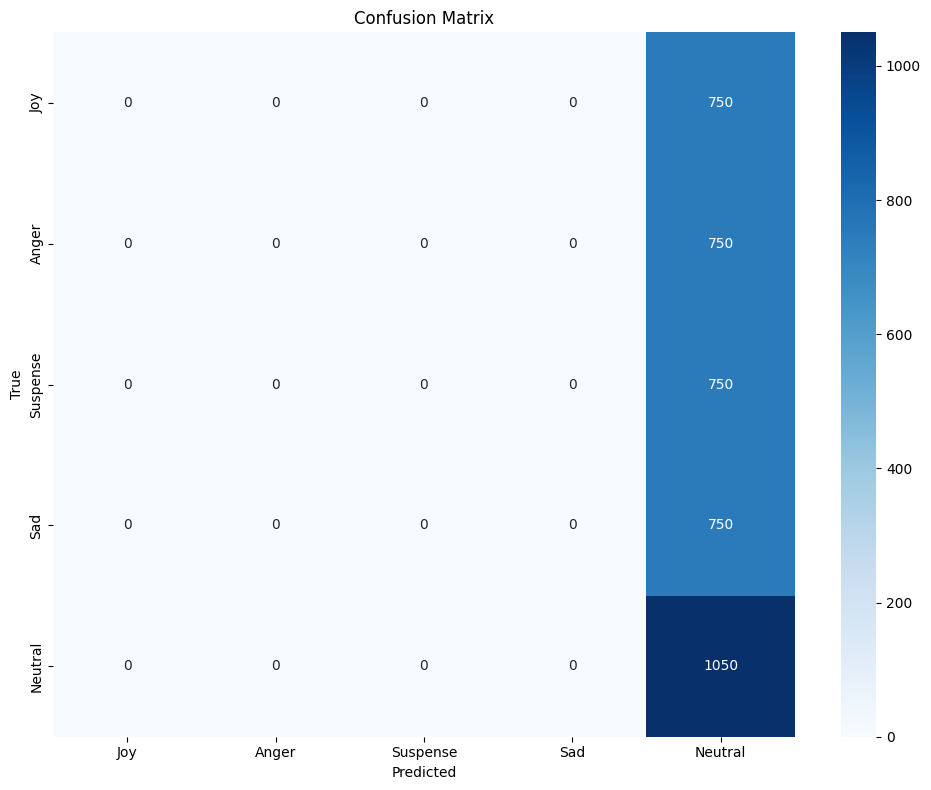

In [ ]:
import argparse
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from transformers import get_linear_schedule_with_warmup
import wandb
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize argument parser
parser = argparse.ArgumentParser(description="Fine-tune for Bhaav 5-Emotion Classification")
parser.add_argument("--embeddings_path", type=str, default="indicbert_embeddings_resampled.npy")
parser.add_argument("--data_path", type=str, default="tokenized_dataset_resampled.csv")
parser.add_argument("--output_dir", type=str, default="bhaav_emotion_model")
parser.add_argument("--batch_size", type=int, default=32)
parser.add_argument("--learning_rate", type=float, default=3e-5)
parser.add_argument("--weight_decay", type=float, default=0.01)
parser.add_argument("--num_epochs", type=int, default=5)
parser.add_argument("--warmup_ratio", type=float, default=0.1)
parser.add_argument("--seed", type=int, default=42)
parser.add_argument("--use_wandb", action="store_true", help="Enable Weights & Biases logging")
parser.add_argument("--fp16", action="store_true", help="Use mixed precision training")
args, unknown = parser.parse_known_args()


# Set seed for reproducibility
torch.manual_seed(args.seed)
np.random.seed(args.seed)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define emotion mapping
EMOTION_LABELS = {
    0: "Joy",
    1: "Anger",
    2: "Suspense",
    3: "Sad",
    4: "Neutral"
}

# Initialize W&B if enabled
if args.use_wandb:
    wandb.init(
        project="bhaav-emotion-analysis",
        config={
            "emotions": list(EMOTION_LABELS.values()),
            "batch_size": args.batch_size,
            "learning_rate": args.learning_rate,
            "weight_decay": args.weight_decay,
            "epochs": args.num_epochs,
            "warmup_ratio": args.warmup_ratio,
        }
    )

# Load preprocessed data and embeddings
print("Loading preprocessed data and embeddings...")
data = pd.read_csv(args.data_path)
embeddings = np.load(args.embeddings_path)

print(f"Data shape: {data.shape}")
print(f"Embeddings shape: {embeddings.shape}")
print("Emotion distribution:")
emotion_counts = data['Annotation'].value_counts().sort_index()
for emotion_id, count in emotion_counts.items():
    print(f"  {EMOTION_LABELS[emotion_id]}: {count}")

# Split data into train/val/test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    embeddings,
    data['Annotation'].values,
    test_size=0.15,
    random_state=args.seed,
    stratify=data['Annotation'].values
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.15,
    random_state=args.seed,
    stratify=y_train_val
)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

# Create PyTorch datasets
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long)
)
val_dataset = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.long)
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.long)
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size)

# Define a model that uses pre-computed embeddings
class EmotionClassifier(torch.nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super(EmotionClassifier, self).__init__()
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

# Initialize model
input_dim = embeddings.shape[1]  # Dimension of the embeddings
model = EmotionClassifier(input_dim).to(device)

# Set up optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
total_steps = len(train_loader) * args.num_epochs
warmup_steps = int(total_steps * args.warmup_ratio)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Set up mixed precision training if enabled
if args.fp16 and torch.cuda.is_available():
    scaler = torch.cuda.amp.GradScaler()
    print("Using mixed precision training (FP16)")
else:
    scaler = None
    if args.fp16:
        print("FP16 requested but not available, using FP32 instead")
    else:
        print("Using FP32 precision")

# Training loop
best_val_f1 = 0
print("Starting training...")

for epoch in range(args.num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    train_preds = []
    train_labels = []

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{args.num_epochs} [Train]")
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        if scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            # Backward pass with scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

        scheduler.step()

        # Collect statistics
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_preds.extend(predicted.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

        # Update progress bar
        progress_bar.set_postfix({"loss": loss.item()})

    # Calculate training metrics
    train_acc = accuracy_score(train_labels, train_preds)
    train_f1 = f1_score(train_labels, train_preds, average='weighted')
    train_loss = train_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{args.num_epochs} [Val]")
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Collect statistics
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

            # Update progress bar
            progress_bar.set_postfix({"loss": loss.item()})

    # Calculate validation metrics
    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average='weighted')
    val_loss = val_loss / len(val_loader)

    # Per-class F1 scores
    per_class_f1 = f1_score(val_labels, val_preds, average=None)
    emotion_f1 = {EMOTION_LABELS[i]: f1 for i, f1 in enumerate(per_class_f1)}

    # Print epoch results
    print(f"Epoch {epoch+1}/{args.num_epochs}:")
    print(f"  Train - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, F1: {train_f1:.4f}")
    print(f"  Val   - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1: {val_f1:.4f}")
    print("  F1 scores per emotion:")
    for emotion, f1 in emotion_f1.items():
        print(f"    {emotion}: {f1:.4f}")

    # Log to W&B if enabled
    if args.use_wandb:
        log_dict = {
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "train_f1": train_f1,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "val_f1": val_f1,
        }
        # Add per-emotion F1 scores
        for emotion, f1 in emotion_f1.items():
            log_dict[f"val_f1_{emotion}"] = f1

        wandb.log(log_dict)

    # Save the best model
# Save the best model
# Save the best model
import os

# Ensure output directory exists
output_dir = "bhaav_emotion_model"
os.makedirs(output_dir, exist_ok=True)

if val_f1 > best_val_f1:
    best_val_f1 = val_f1
    best_model_path = os.path.join(args.output_dir, "best_model.pt")

    torch.save(model.state_dict(), best_model_path)
    print(f"  New best model saved with F1: {val_f1:.4f}")

# Load the best model for evaluation
best_model_path = os.path.join(args.output_dir, "best_model.pt")
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Test evaluation
test_preds = []
test_labels = []
test_probs = []


with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probabilities.cpu().numpy())

# Calculate test metrics
test_acc = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds, average='weighted')
per_class_f1 = f1_score(test_labels, test_preds, average=None)
emotion_f1 = {EMOTION_LABELS[i]: f1 for i, f1 in enumerate(per_class_f1)}

print("\nTest Results:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Weighted F1 Score: {test_f1:.4f}")
print("\nF1 Scores per Emotion:")
for emotion, f1 in emotion_f1.items():
    print(f"  {emotion}: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(test_labels, test_preds,
                           target_names=[EMOTION_LABELS[i] for i in range(5)]))

# Create and save confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[EMOTION_LABELS[i] for i in range(5)],
            yticklabels=[EMOTION_LABELS[i] for i in range(5)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig(f"{args.output_dir}/confusion_matrix.png")
print(f"Confusion matrix saved to {args.output_dir}/confusion_matrix.png")

# Log final metrics to W&B
if args.use_wandb:
    log_dict = {
        "test_accuracy": test_acc,
        "test_f1": test_f1,
    }
    # Add per-emotion F1 scores
    for emotion, f1 in emotion_f1.items():
        log_dict[f"test_f1_{emotion}"] = f1

    # Log confusion matrix
    wandb.log(log_dict)
    wandb.log({"confusion_matrix": wandb.Image(f"{args.output_dir}/confusion_matrix.png")})
    wandb.finish()

# Save the final model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'num_classes': 5,
    'input_dim': input_dim,
    'emotion_labels': EMOTION_LABELS,
}, f"{args.output_dir}/final_model.pt")

print("Training and evaluation complete!")

# Create a class for inference
class BhaavEmotionPredictor:
    def __init__(self, model_path, device='cpu'):
        # Load model
        checkpoint = torch.load(model_path, map_location=device)
        self.input_dim = checkpoint['input_dim']
        self.num_classes = checkpoint['num_classes']
        self.emotion_labels = checkpoint['emotion_labels']

        # Initialize model
        self.model = EmotionClassifier(self.input_dim, self.num_classes).to(device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()
        self.device = device

    def predict(self, embedding):
        """
        Predict emotion from precomputed embedding
        """
        with torch.no_grad():
            tensor_input = torch.tensor(embedding, dtype=torch.float32).unsqueeze(0).to(self.device)
            outputs = self.model(tensor_input)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
            prediction = torch.argmax(outputs, dim=1).item()

        result = {
            'emotion': self.emotion_labels[prediction],
            'emotion_id': prediction,
            'confidence': probabilities[prediction].item(),
            'probabilities': {self.emotion_labels[i]: prob.item() for i, prob in enumerate(probabilities)}
        }

        return result

# Example usage of the predictor
print("\nCreate an emotion predictor with:")
print("predictor = BhaavEmotionPredictor(model_path='{args.output_dir}/final_model.pt')")
print("result = predictor.predict(embedding)")

#below is useless stuff, tried random methods of preprocessing and training


In [ ]:
# ------------------------- Emotion Classification Pipeline for Hindi Text -------------------------

import re
import os
from inltk.inltk import setup, tokenize_text  # iNLTK functions for tokenization
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Setup iNLTK for Hindi (this downloads required models if not already present)
setup('hi')

# Define a regex pattern to remove punctuation.
# The pattern removes any character that is not a word character, whitespace, or the Hindi danda (।)
punctuation_pattern = r'[^\w\s।]'

# Define a set of Hindi stopwords and pronouns to remove (you can expand this list as needed)
hindi_stopwords = {
    "और", "में", "की", "का", "है", "हूँ", "था", "थे", "हो", "जो", "से", "पर",
    "इस", "उन", "वह", "यह", "वे", "मैं", "तुम", "आप", "इन्हें", "उन्हें", "मे", "के"
}

def preprocess_sentence(sentence):
    """
    Preprocess a single Hindi sentence:
    - Tokenize using iNLTK.
    - Remove punctuation from tokens.
    - Remove tokens that are stop words or pronouns.
    - Rejoin tokens to form a cleaned sentence.
    """
    # Tokenize the sentence into words using iNLTK
    tokens = tokenize_text(sentence, language='hi')

    # Remove punctuation from each token
    tokens = [re.sub(punctuation_pattern, '', token) for token in tokens]

    # Remove any empty tokens (which might be created after punctuation removal)
    tokens = [token for token in tokens if token.strip() != '']

    # Remove stopwords and pronouns
    tokens = [token for token in tokens if token not in hindi_stopwords]

    # Rejoin tokens back into a single string (cleaned sentence)
    cleaned_sentence = ' '.join(tokens)
    return cleaned_sentence

def load_sentences_from_file(file_path):
    """
    Load sentences from an input file.
    Assumes the file contains one sentence per line.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        sentences = f.read().splitlines()
    return sentences

def emotion_classification_pipeline(input_file):
    """
    Main pipeline:
    1. Loads sentences from an input file.
    2. Preprocesses each sentence.
    3. Encodes the preprocessed text using TF-IDF.
    """
    # Load sentences from the input file
    sentences = load_sentences_from_file(input_file)

    # Preprocess each sentence using the defined function
    preprocessed_sentences = [preprocess_sentence(sentence) for sentence in sentences]

    # Encode the text using TF-IDF vectorization
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(preprocessed_sentences)

    # For demonstration: print the shape of the TF-IDF matrix and a sample of feature names
    print("TF-IDF matrix shape:", tfidf_matrix.shape)
    print("Sample feature names:", vectorizer.get_feature_names_out()[:20])

    # The resulting tfidf_matrix can now be used as input features for any classifier (e.g., SVM, Logistic Regression)
    return tfidf_matrix, vectorizer, preprocessed_sentences

# ------------------------- Example Usage -------------------------
if __name__ == "__main__":
    # Replace 'bhaav_dataset.txt' with the path to your input file containing Hindi sentences.
    input_file = 'bhaav_dataset.txt'

    # Run the pipeline
    tfidf_matrix, vectorizer, preprocessed_sentences = emotion_classification_pipeline(input_file)

    # At this point, you would typically proceed with model training using tfidf_matrix as features.


ImportError: cannot import name 'Iterable' from 'collections' (/usr/lib/python3.11/collections/__init__.py)

In [ ]:
# ------------------------- Text Preprocessing, Feature Extraction & Embedding Preparation -------------------------

import pandas as pd
import numpy as np
import re
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from cltk.tokenizers.sentence import TokenizeSentence

from gensim.models import KeyedVectors
from tqdm import tqdm
import pickle

tqdm.pandas()


# ------------------------- Load Dataset -------------------------
def load_dataset(file_path):
    """
    Load the dataset and remove NaN or empty sentences.
    Save the cleaned dataset.
    """
    if os.path.exists('cleaned_dataset.csv'):
        print("Loading preprocessed dataset from 'cleaned_dataset.csv'.")
        return pd.read_csv('cleaned_dataset.csv')

    try:
        data = pd.read_excel(file_path)
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

    data = data.dropna(subset=['Sentences'])
    data = data[data['Sentences'].str.strip() != '']
    data['Annotation'] = data['Annotation'].astype(int)

    print("Original Class Distribution:")
    print(data['Annotation'].value_counts())

    # Save cleaned dataset
    data.to_csv('cleaned_dataset.csv', index=False)
    print("Cleaned dataset saved as 'cleaned_dataset.csv'.")
    return data


# ------------------------- Tokenization -------------------------
def tokenize_sentences(sentences):
    """
    Tokenizes sentences using CLTK's TokenizeSentence (Indic languages support).
    Save the tokenized sentences.
    """
    if os.path.exists('tokenized_sentences.csv'):
        print("Loading preprocessed tokenized sentences from 'tokenized_sentences.csv'.")
        return pd.read_csv('tokenized_sentences.csv')['Tokenized_Sentences']

    tokenizer = TokenizeSentence('sanskrit')  # Using 'sanskrit'; adjust if needed for Hindi
    tokenized = sentences.progress_apply(lambda x: tokenizer.tokenize(x))
    tokenized_df = pd.DataFrame({'Tokenized_Sentences': tokenized})
    tokenized_df.to_csv('tokenized_sentences.csv', index=False)
    print("Tokenized sentences saved as 'tokenized_sentences.csv'.")
    return tokenized


# ------------------------- Punctuation Removal -------------------------
def remove_punctuation(sentences):
    """
    Removes punctuation from sentences.
    Save the cleaned sentences.
    """
    if os.path.exists('cleaned_sentences.csv'):
        print("Loading preprocessed cleaned sentences from 'cleaned_sentences.csv'.")
        return pd.read_csv('cleaned_sentences.csv')['Cleaned_Sentences']

    cleaned = sentences.progress_apply(lambda x: re.sub(r'[^\w\s]', '', x))
    cleaned_df = pd.DataFrame({'Cleaned_Sentences': cleaned})
    cleaned_df.to_csv('cleaned_sentences.csv', index=False)
    print("Cleaned sentences saved as 'cleaned_sentences.csv'.")
    return cleaned


# ------------------------- Feature Extraction (TF-IDF) -------------------------
def extract_tfidf_features(sentences):
    """
    Generates TF-IDF features using Unigrams, Bigrams, and Trigrams.
    Save the vectorizer and matrix.
    """
    if os.path.exists('tfidf_vectorizer.pkl') and os.path.exists('tfidf_matrix.npy'):
        print("Loading preprocessed TF-IDF vectorizer and matrix.")
        with open('tfidf_vectorizer.pkl', 'rb') as f:
            vectorizer = pickle.load(f)
        tfidf_matrix = np.load('tfidf_matrix.npy')
        return tfidf_matrix, vectorizer

    vectorizer = TfidfVectorizer(ngram_range=(1, 3))
    tfidf_matrix = vectorizer.fit_transform(sentences)

    # Save vectorizer and matrix
    with open('tfidf_vectorizer.pkl', 'wb') as f:
        pickle.dump(vectorizer, f)
    np.save('tfidf_matrix.npy', tfidf_matrix.toarray())
    print("TF-IDF vectorizer and matrix saved.")
    return tfidf_matrix, vectorizer


# ------------------------- Load FastText Embeddings -------------------------
def load_fasttext_model(file_path):
    """
    Load pre-trained FastText embeddings.
    """
    return KeyedVectors.load_word2vec_format(file_path, binary=False)


# ------------------------- Sentence Embedding Generation -------------------------
def generate_sentence_embedding(sentence, model, embedding_dim=300, max_len=126):
    words = sentence.split()
    embedding_matrix = np.zeros((max_len, embedding_dim))
    for i, word in enumerate(words[:max_len]):
        if word in model:
            embedding_matrix[i] = model[word]
        else:
            embedding_matrix[i] = np.zeros(embedding_dim)
    return embedding_matrix


# ------------------------- Pad Sentences -------------------------
def pad_sentences(embeddings, max_len=126):
    return np.array([
        np.pad(embedding, ((0, max_len - len(embedding)), (0, 0)), 'constant')
        if len(embedding) < max_len else embedding[:max_len]
        for embedding in embeddings
    ])


# ------------------------- Example Usage -------------------------
file_path = "Bhaav-Dataset(1).xlsx"
data = load_dataset(file_path)

# Tokenization
sentences = data['Sentences']
tokenized_sentences = tokenize_sentences(sentences)
data['Tokenized_Sentences'] = tokenized_sentences

# Punctuation Removal
cleaned_sentences = remove_punctuation(sentences)

# Feature Extraction (TF-IDF)
tfidf_matrix, vectorizer = extract_tfidf_features(cleaned_sentences)

# Load FastText Model (Path to .vec file)
# fasttext_model = load_fasttext_model('cc.hi.300.vec')

# Generate Embeddings (Uncomment below if FastText model is loaded)
# sentence_embeddings = cleaned_sentences.progress_apply(lambda x: generate_sentence_embedding(x, fasttext_model))
# sentence_embeddings_padded = pad_sentences(sentence_embeddings)


ModuleNotFoundError: No module named 'cltk.tokenizers.sentence'

fast text


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
import fasttext.util
import re
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
np.random.seed(42)

# Load the Bhaav dataset
print("Loading the Bhaav dataset...")
df = pd.read_excel('/content/Bhaav-Dataset(1).xlsx')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nColumns in the dataset:")
print(df.columns.tolist())
print("\nEmotion distribution:")
print(df['Annotation'].value_counts())

# Basic preprocessing function for Hindi text
def preprocess_text(text):
    if isinstance(text, str):
        # Remove special characters and digits
        text = re.sub(r'[^\w\s]', '', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ""

# Apply preprocessing to text
print("\nPreprocessing text...")
df['processed_text'] = df['Sentences'].apply(preprocess_text)

# Encode emotion labels
label_encoder = LabelEncoder()
df['emotion_encoded'] = label_encoder.fit_transform(df['Annotation'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'],
    df['emotion_encoded'],
    test_size=0.2,
    random_state=42,
    stratify=df['emotion_encoded']
)

# Load FastText embeddings for Hindi
print("\nLoading FastText embeddings for Hindi...")
if not os.path.exists('/content/cc.hi.300.bin'):
    print("Downloading FastText Hindi embeddings...")
    fasttext.util.download_model('hi', if_exists='ignore')

ft_model = fasttext.load_model('/content/cc.hi.300.bin')

# Function to get FastText sentence embeddings (average of word embeddings)
def get_sentence_embedding(text, model, dim=300):
    words = text.split()
    if not words:
        return np.zeros(dim)

    embeddings = [model.get_word_vector(word) for word in words]
    return np.mean(embeddings, axis=0)

# Generate TF-IDF features with n-grams
print("\nGenerating TF-IDF features with n-grams...")
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),  # Unigrams, Bigrams, and Trigrams
    max_features=10000,
    min_df=2
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Generate FastText embeddings
print("\nGenerating FastText embeddings for sentences...")
X_train_fasttext = np.array([get_sentence_embedding(text, ft_model) for text in tqdm(X_train)])
X_test_fasttext = np.array([get_sentence_embedding(text, ft_model) for text in tqdm(X_test)])

# Set up SVM model with hyperparameter tuning
print("\nTraining SVM model with hyperparameter tuning...")
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf']
}

grid_search = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid,
    cv=5,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_fasttext, y_train)

# Get best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f"\nBest parameters: {best_params}")

# Predict on test set
y_pred = best_model.predict(X_test_fasttext)
y_pred_proba = best_model.predict_proba(X_test_fasttext)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")
print(f"Macro F1-score: {f1:.4f}")

# Get classification report
target_names = label_encoder.classes_
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))



Loading the Bhaav dataset...
Dataset shape: (20304, 2)

Columns in the dataset:
['Sentences', 'Annotation']

Emotion distribution:
Annotation
4    11697
2     3168
1     2463
3     1512
0     1464
Name: count, dtype: int64

Preprocessing text...

Loading FastText embeddings for Hindi...


Generating TF-IDF features with n-grams...

Generating FastText embeddings for sentences...


100%|██████████| 4061/4061 [00:00<00:00, 4230.11it/s]



Training SVM model with hyperparameter tuning...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


TF-IDF

In [ ]:
# Visualize confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix_svm.png')
plt.show()

# Visualize the CV results
plt.figure(figsize=(15, 6))
cv_results = pd.DataFrame(grid_search.cv_results_)

# Plot mean test scores for different configurations
plt.subplot(1, 2, 1)
cv_results_linear = cv_results[cv_results['param_kernel'] == 'linear']
cv_results_linear_grouped = cv_results_linear.groupby('param_C')['mean_test_score'].mean()
plt.plot(cv_results_linear_grouped.index, cv_results_linear_grouped.values, marker='o', label='Linear Kernel')

cv_results_rbf = cv_results[cv_results['param_kernel'] == 'rbf']
rbf_grouped = cv_results_rbf.groupby(['param_C', 'param_gamma'])['mean_test_score']
for gamma in param_grid['gamma']:
    gamma_data = [(c, score) for (c, g), score in rbf_grouped.mean().items() if g == gamma]
    if gamma_data:
        c_values, scores = zip(*gamma_data)
        plt.plot(c_values, scores, marker='o', label=f'RBF Kernel, gamma={gamma}')

plt.xscale('log')
plt.xlabel('C Parameter')
plt.ylabel('Mean F1 Score')
plt.title('Hyperparameter Optimization Results')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot class distribution
plt.subplot(1, 2, 2)
class_counts = df['emotion'].value_counts().sort_index()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Emotion Classes')
plt.xlabel('Emotion Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('hyperparameter_optimization.png')
plt.show()

# Additional visualization: Class-wise performance
plt.figure(figsize=(12, 6))
precision_class, recall_class, f1_class, _ = precision_recall_fscore_support(y_test, y_pred)

class_metrics = pd.DataFrame({
    'Precision': precision_class,
    'Recall': recall_class,
    'F1-Score': f1_class
}, index=target_names)

class_metrics.plot(kind='bar', figsize=(12, 6))
plt.title('Class-wise Performance Metrics')
plt.ylabel('Score')
plt.xlabel('Emotion Class')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('class_wise_performance.png')
plt.show()

# Visualize feature importance for linear SVM if applicable
if best_params['kernel'] == 'linear':
    feature_importance = np.abs(best_model.coef_)
    # Get average importance across all classes
    avg_importance = np.mean(feature_importance, axis=0)

    # For TF-IDF features visualization
    if avg_importance.shape[0] <= 100:  # If we have a reasonable number of features
        plt.figure(figsize=(12, 8))
        # Get feature names if available
        feature_names = tfidf_vectorizer.get_feature_names_out()
        # Take top 20 features
        top_indices = np.argsort(avg_importance)[-20:]
        plt.barh([feature_names[i] for i in top_indices], avg_importance[top_indices])
        plt.title('Top 20 Important Features (TF-IDF)')
        plt.xlabel('Average Feature Importance')
        plt.tight_layout()
        plt.savefig('feature_importance.png')
        plt.show()

# Save results to file
with open('model_results.txt', 'w') as f:
    f.write(f"Best parameters: {best_params}\n")
    f.write(f"Test Accuracy: {accuracy:.4f}\n")
    f.write(f"Macro Precision: {precision:.4f}\n")
    f.write(f"Macro Recall: {recall:.4f}\n")
    f.write(f"Macro F1-score: {f1:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred, target_names=target_names))

print("\nAll results saved to files. Training completed!")

# Create a prediction function
def predict_emotion_hindi(text, model, ft_model, label_encoder):
    # Preprocess the text
    processed_text = preprocess_text(text)

    # Get FastText embedding
    embedding = get_sentence_embedding(processed_text, ft_model)

    # Predict
    prediction = model.predict([embedding])[0]
    probabilities = model.predict_proba([embedding])[0]

    # Get the emotion label
    emotion = label_encoder.inverse_transform([prediction])[0]

    # Get probabilities for all classes
    class_probs = {label_encoder.inverse_transform([i])[0]: prob
                   for i, prob in enumerate(probabilities)}

    return emotion, class_probs

# Example usage of the prediction function
print("\nExample prediction:")
example_text = "मैं आज बहुत खुश हूँ"  # "I am very happy today"
predicted_emotion, class_probs = predict_emotion_hindi(example_text, best_model, ft_model, label_encoder)
print(f"Text: {example_text}")
print(f"Predicted emotion: {predicted_emotion}")
print("Class probabilities:")
for emotion, prob in sorted(class_probs.items(), key=lambda x: x[1], reverse=True):
    print(f"  {emotion}: {prob:.4f}")